# Libraries

In [1]:
#import modin.pandas as pd
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import pyplot as plt
from sklearn.utils import resample
from pandas_profiling import ProfileReport
#import pyforest
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, plot_roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score
#from lazypredict.Supervised import LazyRegressor
pd.options.display.max_columns = 100
#pd.set_option('display.max_columns', None)

# Import, Clean, Merge your Key Table

In [3]:
#Import key_table
rain_aus = pd.read_csv("data_rain/rain_data_aus.csv")
rain_aus = rain_aus.rename(columns={"amountOfRain": "amntraintmrw"})
rain_aus['raintoday'].replace({'No': 0, 'Yes': 1},inplace = True)
rain_aus['raintomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)
rain_aus.head()
#Resample and resize variable
no = rain_aus[rain_aus.raintomorrow == 0]
yes = rain_aus[rain_aus.raintomorrow == 1]
yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)
rain_oversample = pd.concat([no, yes_oversampled])
#Plot and see resample
fig = plt.figure(figsize = (8,5))
rain_oversample.raintomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) after Oversampling (Balanced Dataset)')
plt.show()

FileNotFoundError: [Errno 2] File data_rain/rain_data_aus.csv does not exist: 'data_rain/rain_data_aus.csv'

In [8]:
#Import side_tables and concatenate in one
wind1 = pd.read_csv("data_rain/wind_table_01.csv")
wind2 = pd.read_csv("data_rain/wind_table_02.csv")
wind3= pd.read_csv("data_rain/wind_table_03.csv")
wind4 = pd.read_csv("data_rain/wind_table_04.csv")
wind5 = pd.read_csv("data_rain/wind_table_05.csv")
wind6 = pd.read_csv("data_rain/wind_table_06.csv")
wind7 = pd.read_csv("data_rain/wind_table_07.csv")
wind8 = pd.read_csv("data_rain/wind_table_08.csv")
wind = pd.concat([wind1, wind2, wind3, wind4, wind5, wind6, wind7, wind8])
#Correct merged side_tables
cont = 2
for col in wind.columns[8:14]:
    wind.loc[~wind[col].isnull(), wind.columns[cont]] = wind.loc[~wind[col].isnull(), col]
    cont +=1
wind = wind.drop(['windgustdir', 'windgustspeed', 'winddir9am', 'winddir3pm', 'windspeed9am', 'windspeed3pm'], axis=1)

In [9]:
#Merge all tables and apply conditions to correct it
rain_merge = pd.merge(left=rain_aus, right=wind, how='left', on=['date', 'location'])
rain_merge['date'] = pd.to_datetime(rain_merge['date'].str.strip(), format='%Y/%m/%d')
rain_merge.loc[(rain_merge.amntraintmrw < 0.4),'amntraintmrw']=0
#Duplicates
    #rain_merge.groupby(rain_merge.columns.tolist(),as_index=False).size())

In [10]:
#Correct type from columns
rain_merge['wind_gustdir'] = rain_merge['wind_gustdir'].astype(str)
rain_merge['wind_dir9am'] = rain_merge['wind_dir9am'].astype(str)
rain_merge['wind_dir3pm'] = rain_merge['wind_dir3pm'].astype(str)
#turn it into a scale
encoder = LabelEncoder()
encoder.fit(rain_merge['wind_gustdir'])
#transform
rain_merge['wind_gustdir'] = encoder.transform(rain_merge['wind_gustdir'])
rain_merge['wind_dir9am'] = encoder.transform(rain_merge['wind_dir9am'])
rain_merge['wind_dir3pm'] = encoder.transform(rain_merge['wind_dir3pm'])

In [ ]:
#see min and max from table
print(rain_merge['date'].min())
print(rain_merge['date'].max())

In [14]:
#Create a table by your current season (apply one month ago + actual month + next month)
seasoned_rain = rain_merge[(rain_merge['date'].dt.month == 4) | (rain_merge['date'].dt.month == 5) | (rain_merge['date'].dt.month == 6)]
seasoned_rain = seasoned_rain[~(seasoned_rain['date'].dt.year <= 2007)]
#seasoned_rain = seasoned_rain[~(seasoned_rain['date'].dt.year >= 2017)]
#Export your table cleaned
#rain_merge.to_csv('C:/Users/user/2. GIT_PROJECTS/Desafios/Projeto 4 - Itau/case/data/rain_cleaned.csv', index = False, header=True)
#seasoned_rain.to_csv('C:/Users/user/2. GIT_PROJECTS/Desafios/Projeto 4 - Itau/case/data/seasoned_rain.csv', index = False, header=True)

In [ ]:
#Check your final table!
seasoned_rain

# If you want to explore your data with graphs (TAKES TIME!!)

In [ ]:
#Check pairplot if you want to analyze it(takes time to process it!!)
    #pairplot = sns.pairplot(rain_merge)
    #fig = pairplot.get_figure()
    #fig.savefig("rain_merge.png")

In [ ]:
#Check pairplot if you want to analyze it(takes time to process it!!)
    #pairplot = sns.pairplot(seasoned_rain)
    #fig = pairplot.get_figure()
    #fig.savefig("seasoned_rain.png") 

In [ ]:
#Export an automated exploratory analysys (takes time to process it!!)
#prof = ProfileReport(rain_merge, title="Rain in Austraia Seasoned Report", explorative=True)
#prof.to_file(output_file='Australia Rain Seasoned Report.html')

# Predict the future!

In [11]:
#Create you best model variables FOR ALL DATA
X = rain_merge[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = rain_merge['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=50, learning_rate=0.2, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
(np.mean(results), np.std(results))

ROC_AUC_SCORE TRAIN IS:   0.9008708292237316
ROC_AUC_SCORE TEST IS:   0.8877292797208723


(0.8863931663050402, 0.004005189059588628)

In [15]:
#Create you best model variables FOR YOUR SEASONAL CUT
X = seasoned_rain[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = seasoned_rain['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=60, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
(np.mean(results), np.std(results))

ROC_AUC_SCORE TRAIN IS:   0.9211210187170673
ROC_AUC_SCORE TEST IS:   0.9009187540607805


(0.8937993988549241, 0.006679861797309695)

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(precision_score(lgbm.predict(X_test), y_test))
print(recall_score(lgbm.predict(X_test), y_test))
print(f1_score(lgbm.predict(X_test), y_test))

0.5851303508207274
0.7590814196242172
0.6608505997818975


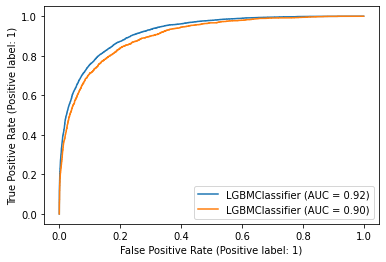

In [17]:
fig, ax = plt.subplots()

plot_roc_curve(lgbm, X_train, y_train, ax=ax)
plot_roc_curve(lgbm, X_test, y_test, ax=ax)

In [ ]:
#If you want to compare with other model (REALLY HEAVY JOB, TAKES TIME!)
    #reg = LazyRegressor(ignore_warnings=False, custom_metric=None)
    #models, predictions = reg.fit(X_train, X_test, y_train, y_test)

In [ ]:
#Try to undersample or oversample more your table by historical series
    #no = rain_merge[rain_merge.date > 3000]
    #yes = rain_merge[rain_merge.date <= 3000]
    #yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)
    #rain_oversample = pd.concat([no, yes_oversampled])

    #fig = plt.figure(figsize = (8,5))
    #rain_oversample.date.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
    #plt.title('RainTomorrow Indicator No(0) and Yes(1) after Oversampling (Balanced Dataset)')
    #plt.show()


# By City

In [ ]:
dfs = dict(tuple(seasoned_rain.groupby('location')))
cities_list = list(dfs)
print(cities_list)

In [ ]:
Adelaide = dfs['Adelaide']
#Create you best model variables
X = Adelaide[['mintemp', 'maxtemp', 'rainfall', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Adelaide['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
(np.mean(results), np.std(results))

In [ ]:
Albany = dfs['Albany']
#Create you best model variables
X = Albany[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Albany['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
(np.mean(results), np.std(results))

In [ ]:
Albury =  dfs['Albury']
X = Albury[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Albury['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
(np.mean(results), np.std(results))

In [ ]:
AliceSprings = dfs['AliceSprings']
X = AliceSprings[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = AliceSprings['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

In [ ]:
BadgerysCreek = dfs['BadgerysCreek']
X = BadgerysCreek[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = BadgerysCreek['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

In [ ]:
Ballarat = dfs['Ballarat']
X = Ballarat[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Ballarat['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

In [ ]:
Bendigo = dfs['Bendigo']
X = Bendigo[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Bendigo['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

In [ ]:
Brisbane = dfs['Brisbane']
X = Brisbane[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Brisbane['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

In [ ]:
Cairns = dfs['Cairns']
X = Cairns[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Cairns['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

In [ ]:
Canberra = dfs['Canberra']
X = Canberra[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Canberra['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

In [ ]:
Cobar = dfs['Cobar']
X = Cobar[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Cobar['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,  random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

In [ ]:
CoffsHarbour = dfs['CoffsHarbour']
X = CoffsHarbour[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = CoffsHarbour['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

In [ ]:
Dartmoor = dfs['Dartmoor']
X = Dartmoor[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Dartmoor['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

In [ ]:
Darwin = dfs['Darwin']
X = Darwin[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Darwin['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

In [ ]:
GoldCoast = dfs['GoldCoast']
X = GoldCoast[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = GoldCoast['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

In [ ]:
Hobart = dfs['Hobart']
X = Hobart[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Hobart['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=2, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

In [ ]:
Katherine = dfs['Katherine']
X = Katherine[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Katherine['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=4, n_estimators=5, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

In [ ]:
Launceston = dfs['Launceston']
X = Launceston[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Launceston['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

In [ ]:
Melbourne = dfs['Melbourne']
X = Melbourne[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Melbourne['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.2, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

In [ ]:
MelbourneAirport = dfs['MelbourneAirport']
X = MelbourneAirport[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = MelbourneAirport['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

In [ ]:
Mildura = dfs['Mildura']
X = Mildura[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Mildura['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=5, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

In [ ]:
More = dfs['Moree']
X = More[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = More['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

In [ ]:
MountGambier = dfs['MountGambier']
X = MountGambier[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = MountGambier['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

In [ ]:
MountGinini = dfs['MountGinini']
X = MountGinini[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = MountGinini['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

In [ ]:
Newcastle = dfs['Newcastle']
X = Newcastle[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Newcastle['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.2, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

In [ ]:
Nhil = dfs['Nhil']
X = Nhil[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Nhil['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

In [ ]:
NorahHead = dfs['NorahHead']
X = NorahHead[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = NorahHead['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

In [ ]:
NorfolkIsland = dfs['NorfolkIsland']
X = NorfolkIsland[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = NorfolkIsland['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

In [ ]:
Nuriootpa = dfs['Nuriootpa']
X = Nuriootpa[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Nuriootpa['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

In [ ]:
PearceRAAF = dfs['PearceRAAF']
X = PearceRAAF[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = PearceRAAF['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

In [ ]:
Penrith = dfs['Penrith']
X = Penrith[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Penrith['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

In [ ]:
Perth = dfs['Perth']
X = Perth[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Perth['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

In [ ]:
PerthAirport = dfs['PerthAirport']
X = PerthAirport[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = PerthAirport['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

In [ ]:
Portland = dfs['Portland']
X = Portland[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Portland['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

In [ ]:
Richmond = dfs['Richmond']
X = Richmond[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Richmond['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

In [ ]:
Sale = dfs['Sale']
X = Sale[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Sale['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

In [ ]:
SalmonGums = dfs['SalmonGums']
X = SalmonGums[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = SalmonGums['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

In [ ]:
Sydney = dfs['Sydney']
X = Sydney[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Sydney['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.2, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

In [ ]:
Sarimax_model = auto_arima(Sydney),
                       start_P=1,
                       start_q=1,
                       max_p=3,
                       max_q=3,
                       m=12,
                       seasonal=True,
                       d=None,
                       D=1,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)

In [ ]:
SydneyAirport = dfs['SydneyAirport']
X = SydneyAirport[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = SydneyAirport['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

In [ ]:
Townsville = dfs['Townsville']
X = Townsville[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Townsville['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=5, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

In [ ]:
Tuggeranong = dfs['Tuggeranong']
X = Tuggeranong[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Tuggeranong['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

In [ ]:
Uluru = dfs['Uluru']
X = Uluru[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Uluru['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

In [ ]:
WaggaWagga = dfs['WaggaWagga']
X = WaggaWagga[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = WaggaWagga['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

In [ ]:
Walpole = dfs['Walpole']
X = Walpole[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Walpole['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

In [ ]:
Watsonia = dfs['Watsonia']
X = Watsonia[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Watsonia['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

In [ ]:
Williamtow = dfs['Williamtown']
X = Williamtow[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Williamtow['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

In [ ]:
Witchcliffe = dfs['Witchcliffe']
X = Witchcliffe[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Witchcliffe['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

In [ ]:
Wollongong = dfs['Wollongong']
X = Wollongong[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Wollongong['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

In [ ]:
Woomera = dfs['Woomera']
X = Woomera[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Woomera['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))

# More Complex Historical Series Models

## Other simples...

In [ ]:
# line plot of dataset
rain_aus['amntraintmrw'].plot()
plt.show()

# line plot of dataset
rain_merge['amntraintmrw'].plot()
plt.show()

# line plot of dataset
seasoned_rain['amntraintmrw'].plot()
plt.show()

In [ ]:
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from math import sqrt
from numpy import mean
from matplotlib import pyplot

# prepare data
X = rain_merge.values
train, test = X[0:-(2*365)], X[-(2*365):]
# evaluate mean of different number of years
years = [2009, 2010, 2012, 2013, 2014, 2015, 2016, 2017]
scores = list()
for year in years:
    # walk-forward validation
    history = [x for x in train]
    predictions = list()
    for i in range(len(test)):
        # collect obs
        obs = list()
        for y in range(1, year+1):
            obs.append(history[-(y*365)])
        # make prediction
        yhat = mean(obs)
        predictions.append(yhat)
        # observation
        history.append(test[i])
        # report performance
        rmse = sqrt(mean_squared_error(test, predictions))
        scores.append(rmse)
        print('Years=%d, RMSE: %.3f' % (year, rmse))
pyplot.plot(years, scores)
pyplot.show()

## Prophet

In [ ]:
!pip install fbprophet --user

## Sarimax

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random
# contrived dataset
#data = [x + random() for x in range(1, 100)]
# fit model
model = SARIMAX(rain_aus, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(len(rain_aus), len(rain_aus))
print(yhat)

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA,ARIMAResults,ARMA,ARMAResults
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

Sarimax_model = auto_arima(seasoned_rain['raintomorrow'],
                       start_P=1,
                       start_q=1,
                       max_p=3,
                       max_q=3,
                       m=12,
                       seasonal=True,
                       d=None,
                       D=1,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)
Sarimax_model.summary()

In [ ]:
# SARIMAX example
from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random
# contrived dataset
#rain_aus = [x + random() for x in range(1, 100)]
#wind = [x + random() for x in range(101, 200)]
# fit model
model = SARIMAX(rain_aus, exog=wind, order=(2,0,1), seasonal_order=(0, 0, 0, 0))
model_fit = model.fit(disp=False)
# make prediction
exog2 = [200 + random()]
yhat = model_fit.predict(len(rain_aus), len(rain_aus), exog=[exog2])
print(yhat)

In [ ]:
# SARIMAX example
from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random
# contrived dataset
#rain_aus = [x + random() for x in range(1, 100)]
#wind = [x + random() for x in range(101, 200)]
# fit model
model = SARIMAX(rain_aus, exog=wind, order=(2,0,1))
model_fit = model.fit(disp=False)
# make prediction
exog2 = [200 + random()]
yhat = model_fit.predict(len(rain_aus), len(rain_aus), exog=[exog2])
print(yhat)

# If you want to see tables by each city

In [ ]:
Albany = dfs['Albany']
Albury =  dfs['Albury']
AliceSprings = dfs['AliceSprings']
BadgerysCreek = dfs['BadgerysCreek']
Ballarat = dfs['Ballarat']
Bendigo = dfs['Bendigo']
Brisbane = dfs['Brisbane']
Cairns = dfs['Cairns']
Canberra = dfs['Canberra']
Cobar = dfs['Cobar']
CoffsHarbour = dfs['CoffsHarbour']
Dartmoor = dfs['Dartmoor']
Darwin = dfs['Darwin']
GoldCoast = dfs['GoldCoast']
Hobart = dfs['Hobart']
Katherine = dfs['Katherine']
Launceston = dfs['Launceston']
Melbourne = dfs['Melbourne']
MelbourneAirport = dfs['MelbourneAirport']
Mildura = dfs['Mildura']
More = dfs['Moree']
MountGambier = dfs['MountGambier']
MountGinini = dfs['MountGinini']
Newcastle = dfs['Newcastle']
Nhil = dfs['Nhil']
NorahHead = dfs['NorahHead']
NorfolkIsland = dfs['NorfolkIsland']
Nuriootpa = dfs['Nuriootpa']
PearceRAAF = dfs['PearceRAAF']
Penrith = dfs['Penrith']
Perth = dfs['Perth'
PerthAirport = dfs['PerthAirport']
Portland = dfs['Portland']
Richmond = dfs['Richmond']
Sale = dfs['Sale']
SalmonGums = dfs['SalmonGums']
Sydney = dfs['Sydney']
SydneyAirport = dfs['SydneyAirport']
Townsville = dfs['Townsville']
Tuggeranong = dfs['Tuggeranong']
Uluru = dfs['Uluru']
WaggaWagga = dfs['WaggaWagga']
Walpole = dfs['Walpole']
Watsonia = dfs['Watsonia']
Williamtow = dfs['Williamtown']
Witchcliffe = dfs['Witchcliffe']
Wollongong = dfs['Wollongong']

In [ ]:
#Else

#for i, g in seasoned_rain.groupby('location'):
#    globals()['seasoned_rain_city_' + str(i)] =  g

# sort the dataframe
#seasoned_rain.sort_values(by='location', axis=1, inplace=True)

# set the index to be this and don't drop
#seasoned_rain.set_index(keys=['location'], drop=False,inplace=True)

# get a list of names
#locations = seasoned_rain['location'].unique().tolist()
#locations
# now we can perform a lookup on a 'view' of the dataframe
#joe = df.loc[df.name=='joe']

# now you can query all 'joes'